In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

import tensorflow as tf
#from tensorflow import keras
from tensorflow.data import Dataset

from tensorflow.keras import Sequential, Input
from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation

from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomContrast
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, Rescaling

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import UpSampling2D, GlobalAveragePooling2D

In [3]:
AUTO = tf.data.experimental.AUTOTUNE
# Detect hardware, return appropriate distribution strategy
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
print('Running on TPU ', tpu.master())

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


Geting datasets

In [4]:
base = '/kaggle/working/'
base_2 = '/kaggle/input/'
x_data = np.load(base_2 + 'cifar100/x_train.npy')
y_data = np.load(base_2 + 'cifar100/y_train.npy')
x_test = np.load(base_2 + 'cifar100/x_test.npy')

# Separo en train y validacion
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.2, 
                                                      random_state=13, stratify=y_data)

y_train_a = [i[0] for i in y_train]
y_valid_a = [i[0] for i in y_valid]

In [5]:
# Data augmentation layer
data_augmentation = Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.3),
        RandomContrast(0.2),
    ]
)

### Configurations

In [6]:
BATCH_SIZE= 64 * strategy.num_replicas_in_sync
EPOCHS = 20
CLASSES = 100
IMAGE_SIZE = 32

In [7]:
LR_START = 0.0001
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

def lrsched(epoch):
    if epoch < 4:
        lr = 1e-4
    else:
        lr = 1e-4 * (0.8 ** (epoch - 4))
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [8]:
train_dataset = Dataset.from_tensor_slices((x_train,y_train)).batch(BATCH_SIZE).cache().prefetch(AUTO)
valid_dataset = Dataset.from_tensor_slices((x_valid,y_valid)).batch(BATCH_SIZE).cache().prefetch(AUTO)

### Creating Model

In [9]:
def make_model():
    with strategy.scope():
        inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
        # Image augmentation block
        # x = data_augmentation(inputs)

        # Entry block
        x = Rescaling(1.0 / 255)(inputs)
        x = UpSampling2D(size=(7,7))(x)

        mod = DenseNet201(weights='imagenet', include_top=False, input_tensor=x)

        #for lay in mod.layers:
        #    lay.trainable = False

        x = GlobalAveragePooling2D()(mod.layers[-1].output)
         
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.25)(x)
        x = BatchNormalization()(x)
        
        outputs = Dense(CLASSES, activation="softmax")(x)
        model = Model(inputs, outputs)
        opt = Adam(1e-4)
        model.compile(optimizer=opt,loss="sparse_categorical_crossentropy",metrics=["accuracy"],steps_per_execution=32)
        return model
    
model = make_model()

74842112/74836368 [==============================] - 2s 0us/step


In [10]:
name = base + 'dense_net_mod_v4.h5'
check = ModelCheckpoint(name, monitor='val_accuracy', save_best_only=True,save_weights_only=True,mode='max')
history = model.fit(train_dataset, 
                    validation_data=valid_dataset,
                    callbacks=[check, lr_callback],
                    epochs=EPOCHS)

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
79/79 [==============================] - 391s 5s/step - loss: 3.8165 - accuracy: 0.1784 - val_loss: 2.9071 - val_accuracy: 0.3742
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0003333333333333333.
79/79 [==============================] - 25s 316ms/step - loss: 1.4289 - accuracy: 0.6507 - val_loss: 1.6009 - val_accuracy: 0.6125
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005666666666666667.
79/79 [==============================] - 25s 316ms/step - loss: 0.6936 - accuracy: 0.8154 - val_loss: 1.3407 - val_accuracy: 0.6597
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0008.
79/79 [==============================] - 25s 316ms/step - loss: 0.4520 - accuracy: 0.8745 - val_loss: 1.5841 - val_accuracy: 0.6147
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0006420000000000001.
79/79 [=================

In [11]:
model.load_weights(name)

Text(0, 0.5, 'Accuracy')

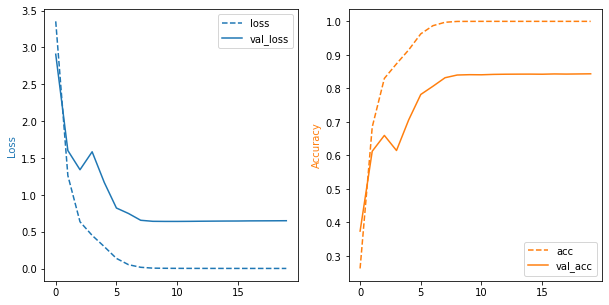

In [12]:
hist = history.history
plt.figure(figsize=(10,5))
    
ax = plt.subplot(1,2,1)
ax.plot(hist['loss'],'C0--',label='loss')
ax.plot(hist['val_loss'],'C0',label='val_loss')
ax.legend()
ax.set_ylabel('Loss', color='C0')

ax = plt.subplot(1,2,2) 
ax.plot(hist['accuracy'],'C1--',label='acc')
ax.plot(hist['val_accuracy'],'C1',label='val_acc')
ax.legend()
ax.set_ylabel('Accuracy', color='C1')

In [ ]:
prediction = model.predict(x_test).argmax(axis=-1)
df = pd.DataFrame(prediction, columns=['label'])
df.index.name = 'Id'
df.to_csv('{}submission_{}.csv'.format(base, 1))

In [ ]:
train_pred = model.predict(x_train).argmax(axis=-1)
acc_train = sum(train_pred == y_train_a) / len(train_pred)

valid_pred = model.predict(x_valid).argmax(axis=-1)
acc_valid = sum(valid_pred == y_valid_a) / len(valid_pred)
acc_train, acc_valid